# First Attempt (Can Mildly Disregard)

This was a first-attempt at trying to get everything to run. Most of what is important here is the pre-processing done to extract out the ``` hemorrhage_CT ``` file along with the ``` mini_dataset ``` that was going to be used for training but ended up not being as useful as initially planned.

**Importing and Preprocessing**

In [2]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def center_crop(tensor, target_tensor):
    _, _, h, w = tensor.size()
    _, _, th, tw = target_tensor.size()
    dh = (h - th) // 2
    dw = (w - tw) // 2
    return tensor[:, :, dh:dh+th, dw:dw+tw]

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))
        mid = self.middle(self.pool4(e4))

        u4 = self.up4(mid)
        e4 = center_crop(e4, u4)
        d4 = self.decoder4(torch.cat([u4, e4], dim=1))

        u3 = self.up3(d4)
        e3 = center_crop(e3, u3)
        d3 = self.decoder3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        e2 = center_crop(e2, u2)
        d2 = self.decoder2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        e1 = center_crop(e1, u1)
        d1 = self.decoder1(torch.cat([u1, e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])
        image = Image.open(img_path).convert('L')  # grayscale
        mask = Image.open(mask_path).convert('L')

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [5]:
def collect_image_mask_pairs(root_dir):
    image_mask_pairs = []

    for patient_folder in os.listdir(root_dir):
        brain_folder = os.path.join(root_dir, patient_folder, "brain")
        if not os.path.isdir(brain_folder):
            continue

        images = [f for f in os.listdir(brain_folder) if f.endswith(".jpg") and "_HGE_Seg" not in f]

        for img_name in images:
            base_name = img_name.replace(".jpg", "")
            seg_name = f"{base_name}_HGE_Seg.jpg"
            img_path = os.path.join(brain_folder, img_name)
            mask_path = os.path.join(brain_folder, seg_name)
            if os.path.exists(mask_path):
                image_mask_pairs.append((img_path, mask_path))
            else:
                # You can skip or use a blank mask
                image_mask_pairs.append((img_path, None))
    
    return image_mask_pairs

In [6]:
class BrainTumorPatientDataset(Dataset):
    def __init__(self, image_mask_list, use_blank_mask=True):
        self.data = image_mask_list
        self.use_blank_mask = use_blank_mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        image = Image.open(img_path).convert('L')
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        if mask_path:
            mask = Image.open(mask_path).convert('L')
            mask = np.array(mask) / 255.0
        else:
            if self.use_blank_mask:
                mask = np.zeros_like(image[0])
            else:
                raise ValueError(f"Missing mask for image: {img_path}")

        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [7]:
# Set root directory to wherever your dataset lives
root_dir = "computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT"

# Step 1: collect pairs
pairs = collect_image_mask_pairs(root_dir)

# Step 2: create dataset
dataset = BrainTumorPatientDataset(pairs)

# Step 3: load
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

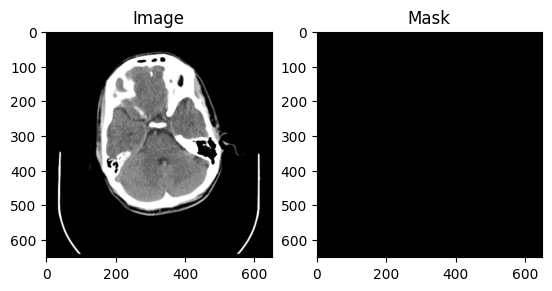

In [8]:
import matplotlib.pyplot as plt

for img, mask in loader:
    plt.subplot(1, 2, 1)
    plt.imshow(img[0][0], cmap='gray')
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0][0], cmap='gray')
    plt.title("Mask")
    plt.show()
    break

**Making new directory for just hemorrage CTs**

In [9]:
import os
import shutil

def partition_segmented_dataset(root_dir, output_dir):
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)

    count = 0

    for patient_folder in os.listdir(root_dir):
        brain_folder = os.path.join(root_dir, patient_folder, "brain")
        if not os.path.isdir(brain_folder):
            continue

        images = [f for f in os.listdir(brain_folder) if f.endswith(".jpg") and "_HGE_Seg" not in f]

        for img_name in images:
            base_name = img_name.replace(".jpg", "")
            seg_name = f"{base_name}_HGE_Seg.jpg"
            img_path = os.path.join(brain_folder, img_name)
            mask_path = os.path.join(brain_folder, seg_name)

            if os.path.exists(mask_path):
                new_img_name = f"{patient_folder}_{img_name}"
                new_mask_name = f"{patient_folder}_{seg_name}"

                shutil.copy(img_path, os.path.join(output_dir, "images", new_img_name))
                shutil.copy(mask_path, os.path.join(output_dir, "masks", new_mask_name))
                count += 1

    print(f"✅ {count} image-mask pairs with segmentation were copied to '{output_dir}'")

In [10]:
output_dir = "hemorrhage_CT"

partition_segmented_dataset(root_dir, output_dir)

✅ 318 image-mask pairs with segmentation were copied to 'hemorrhage_CT'


**Making a small dataset to run on computer**

In [11]:
import random
def create_mini_dataset_from_hemorrhage_ct(source_dir, output_dir, total_samples=30, train_ratio=0.6):
    image_dir = os.path.join(source_dir, "images")
    mask_dir = os.path.join(source_dir, "masks")

    # Get all image filenames (assumes all have matching masks)
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    random.seed(42)
    random.shuffle(image_files)

    # Take a subset of 30
    selected_images = image_files[:total_samples]
    split_idx = int(train_ratio * total_samples)

    # Define output folders
    train_img_out = os.path.join(output_dir, "train/images")
    train_mask_out = os.path.join(output_dir, "train/masks")
    test_img_out = os.path.join(output_dir, "test/images")
    test_mask_out = os.path.join(output_dir, "test/masks")

    os.makedirs(train_img_out, exist_ok=True)
    os.makedirs(train_mask_out, exist_ok=True)
    os.makedirs(test_img_out, exist_ok=True)
    os.makedirs(test_mask_out, exist_ok=True)

    for i, img_file in enumerate(selected_images):
        mask_file = img_file.replace(".jpg", "_HGE_Seg.jpg")

        img_src = os.path.join(image_dir, img_file)
        mask_src = os.path.join(mask_dir, mask_file)

        if not os.path.exists(mask_src):
            print(f"⚠️  Skipping {img_file} — mask not found.")
            continue

        if i < split_idx:
            img_dst = os.path.join(train_img_out, img_file)
            mask_dst = os.path.join(train_mask_out, mask_file)
        else:
            img_dst = os.path.join(test_img_out, img_file)
            mask_dst = os.path.join(test_mask_out, mask_file)

        shutil.copy(img_src, img_dst)
        shutil.copy(mask_src, mask_dst)

    print(f"✅ Mini dataset created at '{output_dir}' with {split_idx} training and {total_samples - split_idx} testing samples.")

In [12]:
create_mini_dataset_from_hemorrhage_ct(
    source_dir="hemorrhage_CT",
    output_dir="mini_dataset",
    total_samples=30,
    train_ratio=0.6
)

✅ Mini dataset created at 'mini_dataset' with 18 training and 12 testing samples.


In [13]:
create_mini_dataset_from_hemorrhage_ct(
    source_dir="hemorrhage_CT",
    output_dir="mini_dataset1",
    total_samples=30,
    train_ratio=0.9
)

✅ Mini dataset created at 'mini_dataset1' with 27 training and 3 testing samples.


**Training Model**

In [14]:
# from torch.utils.data import DataLoader
# import torch.nn as nn
# import torch

# def train(model, dataloader, epochs=10, lr=1e-3, device="cpu"):
#     model = model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.BCELoss()

#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0.0
#         for images, masks in dataloader:
#             images = images.to(device)
#             masks = masks.to(device)

#             preds = model(images)
#             loss = criterion(preds, masks)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [15]:
from torchvision import transforms

class ImageMaskFolderDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(256, 256)):
        self.image_paths = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = transforms.Resize(size)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        mask_name = image_name.replace(".jpg", "_HGE_Seg.jpg")

        img_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        image = self.resize(image)
        mask = self.resize(mask)

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Paths to your mini dataset
train_image_dir = "mini_dataset/train/images"
train_mask_dir = "mini_dataset/train/masks"
test_image_dir = "mini_dataset/test/images"
test_mask_dir = "mini_dataset/test/masks"

# Load datasets
train_dataset = ImageMaskFolderDataset(train_image_dir, train_mask_dir)
test_dataset = ImageMaskFolderDataset(test_image_dir, test_mask_dir)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

**New Training Code**

In [17]:
class DiceLoss(nn.Module):
    """ Dice loss for better loss function
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)

        intersection = (pred * target).sum(dim=1)
        union = pred.sum(dim=1) + target.sum(dim=1)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()  # we minimize loss, so return 1 - dice

In [18]:
def train(model, dataloader, epochs=1, lr=1e-4, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = DiceLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

In [19]:
def evaluate(model, dataloader, device="cpu", visualize=True):
    model.eval()
    model.to(device)

    total_samples = 0
    total_correct = 0

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            preds_bin = (preds > 0.5).float()

            # Per-image success: does prediction overlap with ground truth at all?
            overlap = ((preds_bin * masks) > 0).float().sum(dim=(1,2,3))
            gt_positive = (masks > 0).float().sum(dim=(1,2,3))

            # Only count as success if ground truth has hemorrhage *and* model predicts at least one correct pixel
            success = (gt_positive > 0) & (overlap > 0)
            total_correct += success.sum().item()
            total_samples += images.size(0)

            # Optional: show the first few examples
            if visualize and i < 4:
                for j in range(images.size(0)):
                    show_prediction(images[j], masks[j], preds_bin[j], idx=i*images.size(0)+j)

    acc = total_correct / total_samples
    print(f"[Binary Evaluation] Image-level Accuracy: {acc*100:.2f}%")

In [20]:
def show_prediction(image, mask, pred, idx=0):
    image = image.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Prediction")
    plt.suptitle(f"Sample {idx}")
    plt.show()

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Train
train(model, train_loader, epochs=5, lr=1e-4, device=device)

# Evaluate
evaluate(model, test_loader, device=device, visualize=True)

NameError: name 'model' is not defined

**Trying something new**

In [ ]:
import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.
    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()
 
try:
    print_structure('Fashion_CNN.h5')
except:
    pass

In [ ]:
def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def jacard_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
# Final model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile with custom loss/metrics if needed
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coeff, jacard_coeff])

# To load weights
model.load_weights("Brain_tumour_model_mask.h5")

In [ ]:
def train(model, X_train, Y_train, epochs=1, batch_size=4):
    history = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    return history

# ----------- EVALUATE FUNCTION -----------
def evaluate(model, X_test, Y_test, visualize=True):
    preds = model.predict(X_test)
    preds_bin = (preds > 0.5).astype('float32')

    total = len(X_test)
    correct = 0

    for i in range(total):
        pred_mask = preds_bin[i]
        gt_mask = Y_test[i]

        overlap = np.logical_and(pred_mask > 0, gt_mask > 0).sum()
        gt_positive = (gt_mask > 0).sum()

        # Success if GT has hemorrhage and prediction overlaps with it
        if gt_positive > 0 and overlap > 0:
            correct += 1

        # Optional: visualize first few
        if visualize and i < 4:
            show_prediction(X_test[i], gt_mask, pred_mask, idx=i)

    acc = correct / total
    print(f"[Binary Evaluation] Image-level Accuracy: {acc*100:.2f}%")

# ----------- VISUALIZATION FUNCTION -----------
def show_prediction(image, mask, pred, idx=0):
    if image.shape[-1] == 1:
        image = image.squeeze(-1)
    mask = mask.squeeze()
    pred = pred.squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Prediction")
    plt.suptitle(f"Sample {idx}")
    plt.show()

In [ ]:
def dataset_to_numpy(dataloader, target_size=(128, 128)):
    images = []
    masks = []
    for img, mask in dataloader:
        img = img.squeeze().numpy()  # from [1, H, W] to [H, W]
        mask = mask.squeeze().numpy()

        # Resize both to 128x128
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Normalize and binarize
        img = img.astype('float32') / 255.0
        mask = (mask > 0).astype('float32')

        # Expand dims
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
        img = np.repeat(img, 3, axis=-1)    # (H, W, 3)
        mask = np.expand_dims(mask, axis=-1)  # (H, W, 1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
X_train, Y_train = dataset_to_numpy(train_loader)
X_test, Y_test = dataset_to_numpy(test_loader)

In [ ]:
train(model, X_train, Y_train, epochs=1)

# Evaluate on held-out data
evaluate(model, X_test, Y_test)

ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.